In [6]:
pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install hf_xet

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install textblob

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 624.3/624.3 kB 11.7 MB/s  0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------------- -------------------------- 0.5/1.5 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 3.8 MB/s  0:00:00

   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ---------------------------------------- 0/2 [nltk]
   ------------------------

Total records: 2191
sentiment
Neutral     1056
Positive     971
Negative     164
Name: count, dtype: int64


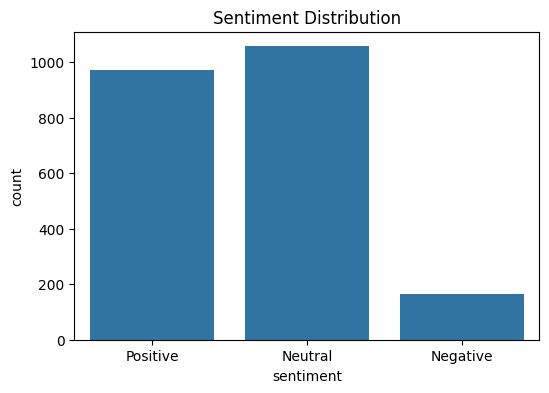

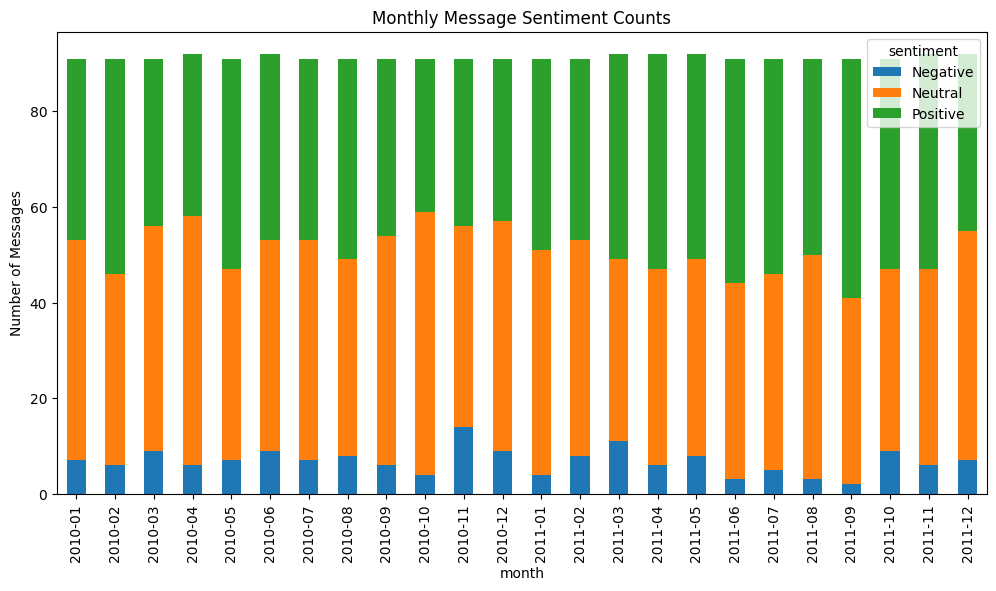

Top 3 Positive employees for 2010-01:
                          from    month  score
120   kayne.coulter@enron.com  2010-01      5
168  patti.thompson@enron.com  2010-01      5
24     don.baughman@enron.com  2010-01      4
Top 3 Negative employees for 2010-01:
                             from    month  score
192      rhonda.denton@enron.com  2010-01      0
96       johnny.palmer@enron.com  2010-01      1
0    bobette.riner@ipgdirect.com  2010-01      2
Flight Risk Employees identified:
                       employee  start_date
0  bobette.riner@ipgdirect.com  2010-11-02
1      johnny.palmer@enron.com  2010-02-25
2      lydia.delgado@enron.com  2011-12-11
3     patti.thompson@enron.com  2011-03-17
4      rhonda.denton@enron.com  2010-12-18
5         sally.beck@enron.com  2010-06-16
Linear Regression MSE: 2.371
Linear Regression R2: 0.665


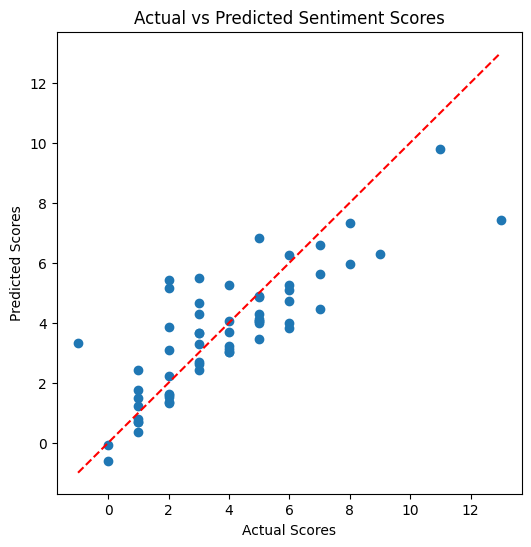

In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from textblob import TextBlob  # For sentiment analysis

# Load dataset
emails = pd.read_csv('test(in).csv')

# Data preprocessing:
# Convert date column to datetime format
emails['date'] = pd.to_datetime(emails['date'], errors='coerce')

# Fill missing message bodies with empty strings
emails['body'] = emails['body'].fillna('')

# Task 1: Sentiment Labeling using TextBlob polarity
def sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

emails['sentiment'] = emails['body'].apply(sentiment_label)

# Task 2: Exploratory Data Analysis (EDA)
print(f"Total records: {len(emails)}")
print(emails['sentiment'].value_counts())

# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=emails)
plt.title('Sentiment Distribution')
plt.show()

# Messages over time (monthly)
emails['month'] = emails['date'].dt.to_period('M')
monthly_counts = emails.groupby(['month', 'sentiment']).size().unstack(fill_value=0)

monthly_counts.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Monthly Message Sentiment Counts')
plt.ylabel('Number of Messages')
plt.show()

# Task 3: Employee Score Calculation (monthly)
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
emails['score'] = emails['sentiment'].map(score_map)

monthly_scores = emails.groupby(['from', 'month'])['score'].sum().reset_index()

# Task 4: Employee Ranking per month
def get_top_employees(month, df=monthly_scores):
    month_df = df[df['month'] == month]
    top_positive = month_df.sort_values(by=['score', 'from'], ascending=[False, True]).head(3)
    top_negative = month_df.sort_values(by=['score', 'from'], ascending=[True, True]).head(3)
    return top_positive, top_negative

# Example for one month:
example_month = monthly_scores['month'].unique()[0]
top_pos, top_neg = get_top_employees(example_month)
print(f"Top 3 Positive employees for {example_month}:\n", top_pos)
print(f"Top 3 Negative employees for {example_month}:\n", top_neg)

# Task 5: Flight Risk Identification
# Define flight risk: 4+ negative mails in rolling 30 day period

# Create dataframe for negative mails only
neg_emails = emails[emails['sentiment'] == 'Negative'].copy()
neg_emails = neg_emails.sort_values(by=['from', 'date'])

# Function to identify flight risks per employee by rolling window
flight_risks = []

for sender, group in neg_emails.groupby('from'):
    dates = group['date'].tolist()
    for i in range(len(dates)):
        window_start = dates[i]
        window_end = window_start + timedelta(days=30)
        count_30day = sum((d >= window_start and d < window_end) for d in dates)
        if count_30day >= 4:
            flight_risks.append((sender, window_start.strftime('%Y-%m-%d')))
            break

flight_risks_df = pd.DataFrame(flight_risks, columns=['employee', 'start_date'])
print("Flight Risk Employees identified:\n", flight_risks_df)

# Task 6: Predictive Modeling
# Features: message frequency per month, average message length, average sentiment polarity per month

# Calculate message counts, avg length and avg polarity per employee per month
emails['length'] = emails['body'].apply(len)
emails['polarity'] = emails['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

features = emails.groupby(['from', 'month']).agg(
    message_count=('body', 'count'),
    avg_length=('length', 'mean'),
    avg_polarity=('polarity', 'mean'),
    sentiment_score=('score', 'sum')
).reset_index()

# Prepare data for regression
X = features[['message_count', 'avg_length', 'avg_polarity']]
y = features['sentiment_score']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions & metrics
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.3f}")
print(f"Linear Regression R2: {r2:.3f}")

# Plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Sentiment Scores')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()
